In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model, ensemble, metrics, model_selection, preprocessing
import joblib

In [2]:
%matplotlib inline

# Predicting Solar Power Output at NEOM

In [3]:
neom_data = (pd.read_csv("../data/raw/neom-data.csv", parse_dates=[0])
               .rename(columns={"Unnamed: 0": "Timestamp"})
               .set_index("Timestamp", drop=True, inplace=False))

In [4]:
neom_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96432 entries, 2008-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 12 columns):
mslp(hPa)          96432 non-null float64
t2(C)              96432 non-null float64
td2(C)             96432 non-null float64
wind_speed(m/s)    96432 non-null float64
wind_dir(Deg)      96432 non-null float64
rh(%)              96432 non-null float64
GHI(W/m2)          96432 non-null float64
SWDIR(W/m2)        96432 non-null float64
SWDNI(W/m2)        96432 non-null float64
SWDIF(W/m2)        96432 non-null float64
rain(mm)           96432 non-null float64
AOD                96432 non-null float64
dtypes: float64(12)
memory usage: 9.6 MB


In [5]:
neom_data.head()

,mslp(hPa),t2(C),td2(C),wind_speed(m/s),wind_dir(Deg),rh(%),GHI(W/m2),SWDIR(W/m2),SWDNI(W/m2),SWDIF(W/m2),rain(mm),AOD
Timestamp,,,,,,,,,,,,
2008-01-01 00:00:00,1012.751,14.887,2.606,2.669,105.078,43.686,0.0,0.0,0.0,0.0,0.0,0.098
2008-01-01 01:00:00,1012.917,14.429,3.363,2.667,106.699,47.442,0.0,0.0,0.0,0.0,0.0,0.098
2008-01-01 02:00:00,1012.966,14.580,3.778,3.341,112.426,48.357,0.0,0.0,0.0,0.0,0.0,0.098
2008-01-01 03:00:00,1013.247,14.390,3.507,3.141,102.371,48.125,0.0,0.0,0.0,0.0,0.0,0.098
2008-01-01 04:00:00,1013.083,14.388,3.869,3.607,111.300,49.295,0.0,0.0,0.0,0.0,0.0,0.098


In [6]:
neom_data.tail()

,mslp(hPa),t2(C),td2(C),wind_speed(m/s),wind_dir(Deg),rh(%),GHI(W/m2),SWDIR(W/m2),SWDNI(W/m2),SWDIF(W/m2),rain(mm),AOD
Timestamp,,,,,,,,,,,,
2018-12-31 19:00:00,1019.779,14.653,4.380,3.587,25.919,50.340,0.0,0.0,0.0,0.0,0.0,0.098
2018-12-31 20:00:00,1019.578,13.965,2.853,2.836,35.203,47.381,0.0,0.0,0.0,0.0,0.0,0.098
2018-12-31 21:00:00,1019.172,13.624,1.923,1.922,85.974,45.275,0.0,0.0,0.0,0.0,0.0,0.098
2018-12-31 22:00:00,1018.610,13.918,1.512,2.512,103.656,43.211,0.0,0.0,0.0,0.0,0.0,0.098
2018-12-31 23:00:00,1018.611,13.442,0.733,3.146,91.084,41.836,0.0,0.0,0.0,0.0,0.0,0.098


In [7]:
neom_data.describe()

,mslp(hPa),t2(C),td2(C),wind_speed(m/s),wind_dir(Deg),rh(%),GHI(W/m2),SWDIR(W/m2),SWDNI(W/m2),SWDIF(W/m2),rain(mm),AOD
count,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000
mean,1010.110794,24.896298,11.045605,3.991582,164.200525,46.168410,274.757261,211.082623,331.746291,63.674490,0.009041,0.098086
std,5.613583,6.382410,7.153472,2.485326,102.793404,17.874776,355.287896,296.287340,390.765915,91.856426,0.173081,0.000805
min,996.378000,4.571000,-22.946000,0.076000,0.672000,5.708000,0.000000,0.000000,0.000000,0.000000,-0.037000,0.096000
25%,1005.539750,20.221000,5.889750,2.152000,62.935500,32.173000,0.000000,0.000000,0.000000,0.000000,0.000000,0.098000
50%,1010.050000,25.421000,11.324500,3.437000,149.692000,44.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.098000
75%,1014.316000,29.466000,16.581250,5.342000,265.977750,58.859000,579.205250,429.275500,788.745750,121.765250,0.000000,0.099000
max,1029.022000,44.186000,27.196000,16.716000,359.620000,99.929000,1103.190000,954.562000,989.816000,856.685000,14.038000,0.100000


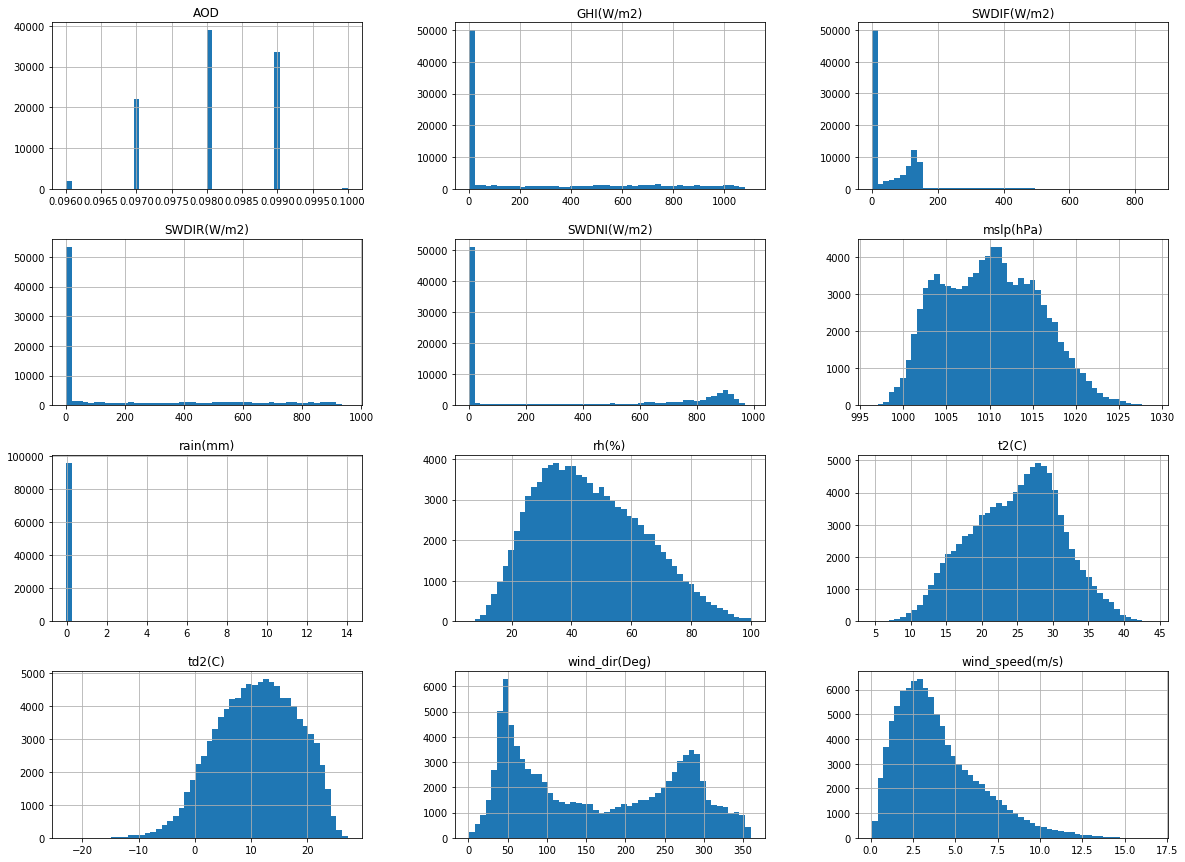

In [8]:
_ = neom_data.hist(bins=50, figsize=(20,15))

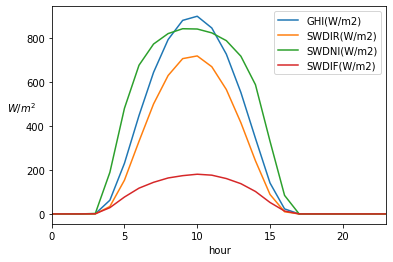

In [9]:
_hour = (neom_data.index
                  .hour
                  .rename("hour"))

hourly_averages = (neom_data.groupby(_hour)
                            .mean())

fig, ax = plt.subplots(1, 1)
_targets = ["GHI(W/m2)", "SWDIR(W/m2)", "SWDNI(W/m2)", "SWDIF(W/m2)"]
(hourly_averages.loc[:, _targets]
                .plot(ax=ax))
_ = ax.set_ylabel(r"$W/m^2$", rotation="horizontal")

In [10]:
months = (neom_data.index
                   .month
                   .rename("month"))
hours = (neom_data.index
                  .hour
                  .rename("hour"))

hourly_averages_by_month = (neom_data.groupby([months, hours])
                                     .mean())

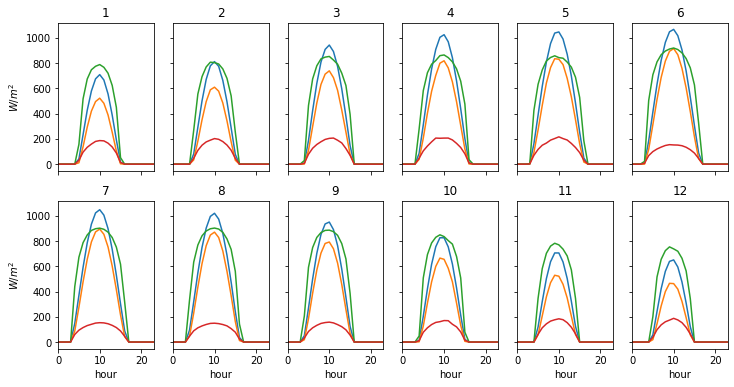

In [11]:
fig, axes = plt.subplots(2, 6, sharex=True, sharey=True, figsize=(12, 6))

for month in months.unique():
    if month <= 6:
        (hourly_averages_by_month.loc[month, _targets]
                                 .plot(ax=axes[0, month - 1], legend=False))
        _ = axes[0, month - 1].set_title(month)
    else:
        (hourly_averages_by_month.loc[month, _targets]
                                 .plot(ax=axes[1, month - 7], legend=False))
        _ = axes[1, month - 7].set_title(month)
    
    if month - 1 == 0: 
        _ = axes[0, 0].set_ylabel(r"$W/m^2$")
    if month - 7 == 0: 
        _ = axes[1, 0].set_ylabel(r"$W/m^2$")
   

# Feature Engineering

In [17]:
neom_data.index.dayofweek.unique()

Int64Index([1, 2, 3, 4, 5, 6, 0], dtype='int64', name='Timestamp')

In [14]:
neom_data.index.weekofyear.unique()

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53],
           dtype='int64', name='Timestamp')

In [38]:
_dropped_cols = ["SWDIR(W/m2)", "SWDNI(W/m2)", "SWDIF(W/m2)"]

_year = (neom_data.index
                  .year)
_month = (neom_data.index
                   .month)
_week = (neom_data.index
                  .weekofyear)
_day = (neom_data.index
                 .dayofweek)
_hour = (neom_data.index
                  .hour)

features = (neom_data.drop(_dropped_cols, axis=1, inplace=False)
                     .assign(year=_year, month=_month, week=_week, day=_day, hour=_hour)
                     .groupby(["year", "month", "week", "day", "hour"])
                     .mean()
                     .unstack(level=["day", "hour"])
                     .reset_index(inplace=False)
                     .sort_index(axis=1)
                     .drop("year", axis=1, inplace=False)
                     .fillna(method="bfill", limit=2, inplace=False))

In [41]:
# want to predict the next 24 hours of "solar power"
efficiency_factor = 0.5

# square meters of solar cells required to generate 20 GW (231000 m2 will generate 7mW)
m2_of_solar_cells_required = 660000

target = (features.loc[:, ["GHI(W/m2)"]]
                  .mul(efficiency_factor)
                  .shift(-1)
                  .rename(columns={"GHI(W/m2)": "target(W/m2)"}))

In [63]:
target

target(W/m2)                                                             \
day             0                                                              
hour           0    1    2    3    4        5         6         7         8    
0             0.0  0.0  0.0  0.0  0.0  15.4625   85.7540  199.4865  279.1695   
1             0.0  0.0  0.0  0.0  0.0  22.0325  128.9640  233.4150  315.5565   
2             0.0  0.0  0.0  0.0  0.0   9.2310   71.1300   97.3875   65.3585   
3             0.0  0.0  0.0  0.0  0.0  24.6660  129.5175  233.2570  316.0465   
4             0.0  0.0  0.0  0.0  0.0  30.6040  140.9780  248.4170  334.1340   
..            ...  ...  ...  ...  ...      ...       ...       ...       ...   
683           0.0  0.0  0.0  0.0  0.0  26.1075   98.4485  163.9655  226.5005   
684           0.0  0.0  0.0  0.0  0.0  33.3755  130.9790  222.7225  291.9230   
685           0.0  0.0  0.0  0.0  0.0  21.9080  122.6125  214.2285  285.8000   
686           0.0  0.0  0.0  0.0  0.0  21.6690  114.3185  214.0540  286.2330   
687           NaN  NaN  NaN  NaN  NaN      NaN       NaN       NaN       NaN   

                ...                                                             
day             ...         6                                                   
hour        9   ...        14       15   16   17   18   19   20   21   22   23  
0     328.9370  ...  103.1305   4.8625  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1     366.3655  ...   74.5395   7.7545  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2     102.5280  ...  119.8195  17.9220  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3     368.8395  ...  136.2110  27.3505  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4     388.3575  ...  136.2110  27.3505  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
..         ...  ...       ...      ...  ...  ...  ...  ...  ...  ...  ...  ...  
683   224.1960  ...   59.4640   0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
684   331.0915  ...   46.6540   0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
685   328.2050  ...   68.8560   0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
686   335.3290  ...   75.8040   0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
687        NaN  ...       NaN      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[688 rows x 168 columns]

In [42]:
input_data = (features.join(target)
                      .dropna(how="any", inplace=False)
                      .sort_index(axis=1))

In [43]:
input_data

AOD                                                                 \
day       0                                                                  
hour     0      1      2      3      4      5      6      7      8      9    
0     0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097   
1     0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097   
2     0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.096  0.096   
3     0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097   
4     0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097   
..      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
682   0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097   
683   0.098  0.098  0.098  0.098  0.098  0.098  0.098  0.098  0.098  0.098   
684   0.098  0.098  0.098  0.098  0.098  0.098  0.098  0.098  0.098  0.098   
685   0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097   
686   0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097  0.097   

      ... wind_speed(m/s)                                                \
day   ...               6                                                 
hour  ...              14     15     16      17      18      19      20   
0     ...           8.923  8.388  9.168   8.932   8.275   7.644   7.218   
1     ...           9.678  8.897  9.666  10.197  10.668  11.314  11.842   
2     ...           2.601  1.350  0.610   0.728   0.907   3.140   2.474   
3     ...           4.836  4.340  3.016   2.484   2.084   2.861   4.209   
4     ...           6.908  5.829  6.632   8.176   8.604   8.674   8.467   
..    ...             ...    ...    ...     ...     ...     ...     ...   
682   ...           2.619  1.129  1.292   1.148   0.652   2.440   2.516   
683   ...           2.619  1.129  1.292   1.148   0.652   2.440   2.516   
684   ...           3.986  3.138  2.724   2.075   2.061   3.872   3.611   
685   ...           2.699  1.082  1.608   2.728   2.096   0.757   0.874   
686   ...           1.157  1.639  4.840   5.091   4.948   5.264   5.263   

                              
day                           
hour      21      22      23  
0      7.145   7.254   7.519  
1     11.067  10.485  10.239  
2      2.689   1.970   2.567  
3      3.804   3.431   3.677  
4      7.488   6.633   5.573  
..       ...     ...     ...  
682    2.264   1.588   1.944  
683    2.264   1.588   1.944  
684    3.181   2.318   1.720  
685    2.458   3.756   3.466  
686    4.680   4.376   3.756  

[687 rows x 1682 columns]

# Train, Test Split

In [69]:
# use first 10 years for training data...
training_data = input_data.loc[:10 * 53]

# ...next two years for validation data...
validation_data = input_data.loc[10 * 53 + 1:12 * 53]

# ...and final year for testing data!
testing_data = input_data.loc[12 * 53 + 1:]

In [70]:
training_data.shape

(531, 1682)

In [71]:
validation_data.shape

(106, 1682)

In [72]:
testing_data.shape

(50, 1682)

# Preprocessing the training and validation data

In [73]:
def preprocess_features(df: pd.DataFrame) -> pd.DataFrame:
    _numeric_features = ["GHI(W/m2)",
                         "mslp(hPa)",
                         "rain(mm)",
                         "rh(%)",
                         "t2(C)",
                         "td2(C)",
                         "wind_dir(Deg)",
                         "wind_speed(m/s)"]

    _ordinal_features = ["AOD",
                         "day",
                         "month",
                         "year"]

    standard_scalar = preprocessing.StandardScaler()
    Z0 = standard_scalar.fit_transform(df.loc[:, _numeric_features])
    
    ordinal_encoder = preprocessing.OrdinalEncoder()
    Z1 = ordinal_encoder.fit_transform(df.loc[:, _ordinal_features])
    transformed_features = np.hstack((Z0, Z1))
    
    return transformed_features



In [74]:
training_features = training_data.drop("target(W/m2)", axis=1, inplace=False)
training_target = training_data.loc[:, ["target(W/m2)"]]
transformed_training_features = preprocess_features(training_features)

validation_features = validation_data.drop("target(W/m2)", axis=1, inplace=False)
validation_target = validation_data.loc[:, ["target(W/m2)"]]
transformed_validation_features = preprocess_features(validation_features)

# Find a few models that seem to work well

## Linear Regression

In [75]:
# training a liner regression model
linear_regression = linear_model.LinearRegression()
linear_regression.fit(transformed_training_features, training_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [76]:
# measure training error
_predictions = linear_regression.predict(transformed_training_features)
np.sqrt(metrics.mean_squared_error(training_target, _predictions))

3.5984482821003514e-13

In [77]:
# measure training error
_predictions = linear_regression.predict(transformed_validation_features)
np.sqrt(metrics.mean_squared_error(validation_target, _predictions))

41.65348268671971

Text(0.5, 0, 'Hour')

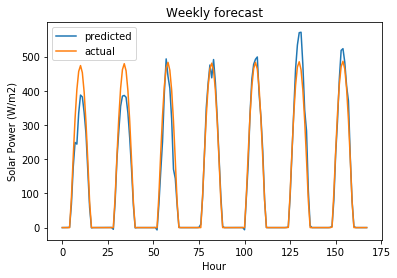

In [79]:
# user requests forecast for some week
user_forecast_request = transformed_validation_features[[-1], :]
user_forecast_response = linear_regression.predict(user_forecast_request)[0]
actual_values_response = validation_target.values[[-1], :][0]

# this would be rendered in Tableau!
plt.plot(user_forecast_response, label="predicted")
plt.plot(actual_values_response, label="actual")
plt.legend()
plt.title("Weekly forecast")
plt.ylabel("Solar Power (W/m2)")
plt.xlabel("Hour")

Linear regression is overfitting!

## MultiTask ElasticNet Regression

In [80]:
# training a multi-task elastic net model
_prng = np.random.RandomState(42)
elastic_net = linear_model.MultiTaskElasticNet(random_state=_prng)
elastic_net.fit(transformed_training_features, training_target)

/Users/pughdr/Research/junctionx-kaust-2019/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1803: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3211704.2181589045, tolerance: 24372.85566059234
  check_random_state(self.random_state), random)


MultiTaskElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
                    max_iter=1000, normalize=False,
                    random_state=<mtrand.RandomState object at 0x1a2be47f30>,
                    selection='cyclic', tol=0.0001, warm_start=False)

In [81]:
# measure training error
_predictions = elastic_net.predict(transformed_training_features)
np.sqrt(metrics.mean_squared_error(training_target, _predictions))

12.62446635442459

In [82]:
# measure validation error
_predictions = elastic_net.predict(transformed_validation_features)
np.sqrt(metrics.mean_squared_error(validation_target, _predictions))

21.755388481701576

Text(0.5, 0, 'Hour')

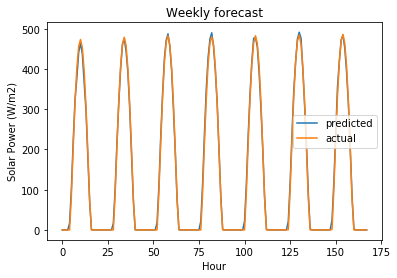

In [83]:
user_forecast_request = transformed_validation_features[[-1], :]
user_forecast_response = elastic_net.predict(user_forecast_request)[0]
actual_values_response = validation_target.values[[-1], :][0]

# this would be rendered in Tableau!
plt.plot(user_forecast_response, label="predicted")
plt.plot(actual_values_response, label="actual")
plt.legend()
plt.title("Weekly forecast")
plt.ylabel("Solar Power (W/m2)")
plt.xlabel("Hour")

MultiTask ElasticNet is still underfitting with default values but does significantly better than plain linear regression.

## MultiTask Lasso Regression

In [84]:
# training a multi-task lasso model
_prng = np.random.RandomState(42)
lasso_regression = linear_model.MultiTaskLasso(random_state=_prng)
lasso_regression.fit(transformed_training_features, training_target)

/Users/pughdr/Research/junctionx-kaust-2019/env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1803: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 344470.44411674794, tolerance: 24372.85566059234
  check_random_state(self.random_state), random)


MultiTaskLasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
               normalize=False,
               random_state=<mtrand.RandomState object at 0x1a2cb81c18>,
               selection='cyclic', tol=0.0001, warm_start=False)

In [85]:
# measure training error
_predictions = lasso_regression.predict(transformed_training_features)
np.sqrt(metrics.mean_squared_error(training_target, _predictions))

9.142156744519834

In [86]:
# measure validation error
_predictions = lasso_regression.predict(transformed_validation_features)
np.sqrt(metrics.mean_squared_error(validation_target, _predictions))

25.11003195102284

Text(0.5, 0, 'Hour')

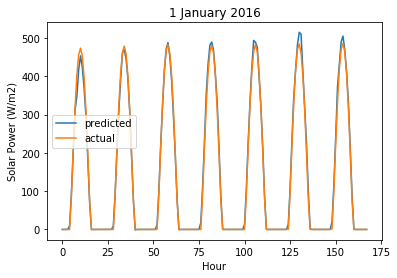

In [87]:
user_forecast_request = transformed_validation_features[[-1], :]
user_forecast_response = lasso_regression.predict(user_forecast_request)[0]
actual_values_response = validation_target.values[[-1], :][0]

# this would be rendered in Tableau!
plt.plot(user_forecast_response, label="predicted")
plt.plot(actual_values_response, label="actual")
plt.legend()
plt.title("1 January 2016")
plt.ylabel("Solar Power (W/m2)")
plt.xlabel("Hour")

Lasso Regression is over-fitting.

## Random Forest Regression

In [88]:
_prng = np.random.RandomState(42)
random_forest_regressor = ensemble.RandomForestRegressor(n_estimators=100, random_state=_prng, n_jobs=2)
random_forest_regressor.fit(transformed_training_features, training_target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                      oob_score=False,
                      random_state=<mtrand.RandomState object at 0x1a2cc2bbd0>,
                      verbose=0, warm_start=False)

In [89]:
# measure training error
_predictions = random_forest_regressor.predict(transformed_training_features)
np.sqrt(metrics.mean_squared_error(training_target, _predictions))

7.011236706071975

In [90]:
# measure validation error
_predictions = random_forest_regressor.predict(transformed_validation_features)
np.sqrt(metrics.mean_squared_error(validation_target, _predictions))

19.32772745697949

Text(0.5, 0, 'Hour')

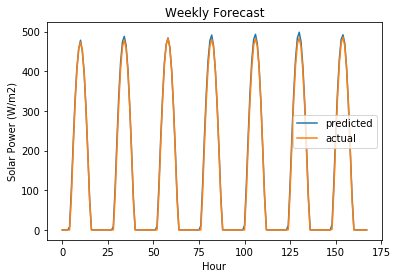

In [92]:
user_forecast_request = transformed_validation_features[[-1], :]
user_forecast_response = random_forest_regressor.predict(user_forecast_request)[0]
actual_values_response = validation_target.values[[-1], :][0]

# this would be rendered in Tableau!
plt.plot(user_forecast_response, label="predicted")
plt.plot(actual_values_response, label="actual")
plt.legend()
plt.title("Weekly Forecast")
plt.ylabel("Solar Power (W/m2)")
plt.xlabel("Hour")

Random Forest with default parameters is over-fitting and needs to be regularized.

# Tuning hyper-parameters

In [93]:
from scipy import stats

## MultiTask ElasticNet Regression

In [94]:
_prng = np.random.RandomState(42)

_param_distributions = {
    "l1_ratio": stats.uniform(),
    "alpha": stats.lognorm(s=1),
}

elastic_net_randomized_search = model_selection.RandomizedSearchCV(
    elastic_net,
    param_distributions=_param_distributions,
    scoring="neg_mean_squared_error",
    random_state=_prng,
    n_iter=10,
    cv=8,
    n_jobs=2,
    verbose=10
)

elastic_net_randomized_search.fit(transformed_training_features, training_target)

Fitting 8 folds for each of 10 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  2.8min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  5.5min


KeyboardInterrupt: 

In [691]:
_ = joblib.dump(elastic_net_randomized_search.best_estimator_,
                "../models/weekly/tuned-elasticnet-regression-model.pkl")

In [651]:
elastic_net_randomized_search.best_estimator_

MultiTaskElasticNet(alpha=2.154232968599504, copy_X=True, fit_intercept=True,
                    l1_ratio=0.9699098521619943, max_iter=1000, normalize=False,
                    random_state=<mtrand.RandomState object at 0x1a48e31558>,
                    selection='cyclic', tol=0.0001, warm_start=False)

In [652]:
(-elastic_net_randomized_search.best_score_)**0.5

18.355092813714375

Text(0.5, 0, 'Hour')

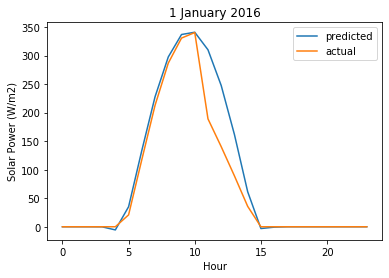

In [653]:
user_forecast_request = transformed_validation_features[[-1], :]
user_forecast_response = elastic_net_randomized_search.predict(user_forecast_request)[0]
actual_values_response = validation_target.values[[-1], :][0]

# this would be rendered in Tableau!
plt.plot(user_forecast_response, label="predicted")
plt.plot(actual_values_response, label="actual")
plt.legend()
plt.title("Typical weekyl forecast")
plt.ylabel("Solar Power (W/m2)")
plt.xlabel("Hour")

## MultiTask Lasso Regression

In [668]:
_prng = np.random.RandomState(42)

_param_distributions = {
    "alpha": stats.lognorm(s=1),
}

lasso_regression_randomized_search = model_selection.RandomizedSearchCV(
    lasso_regression,
    param_distributions=_param_distributions,
    scoring="neg_mean_squared_error",
    random_state=_prng,
    n_iter=10,
    cv=8,
    n_jobs=2,
    verbose=10
)

lasso_regression_randomized_search.fit(transformed_training_features, training_target)

Fitting 8 folds for each of 10 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    9.4s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   16.5s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   22.5s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   30.3s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   38.4s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   48.6s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:  1.8min finished


RandomizedSearchCV(cv=8, error_score='raise-deprecating',
                   estimator=MultiTaskLasso(alpha=1.0, copy_X=True,
                                            fit_intercept=True, max_iter=1000,
                                            normalize=False,
                                            random_state=<mtrand.RandomState object at 0x1a649d5870>,
                                            selection='cyclic', tol=0.0001,
                                            warm_start=False),
                   iid='warn', n_iter=10, n_jobs=2,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a7af2b470>},
                   pre_dispatch='2*n_jobs',
                   random_state=<mtrand.RandomState object at 0x1a69473438>,
                   refit=True, return_train_score=False,
                   scoring='neg_mean_squared_error', verbose=10)

In [689]:
_ = joblib.dump(lasso_regression_randomized_search.best_estimator_,
                "../models/weekly/tuned-lasso-regression-model.pkl")

In [669]:
(-lasso_regression_randomized_search.best_score_)**0.5

17.956920842745834

Text(0.5, 0, 'Hours')

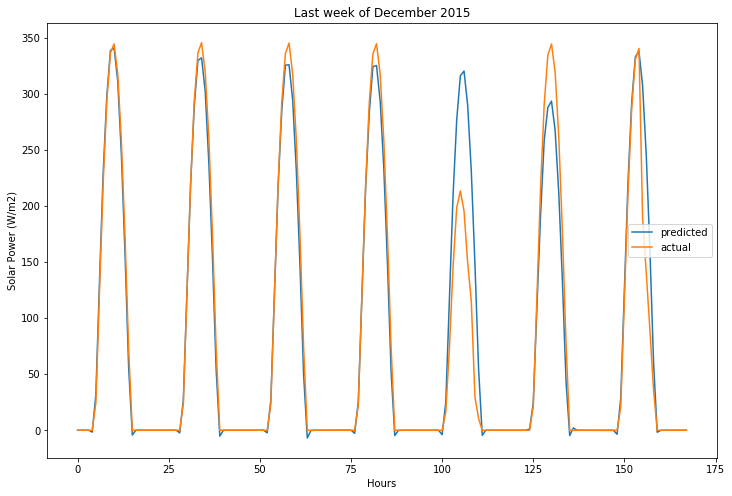

In [671]:
user_forecast_request = transformed_validation_features[-7:, :]
user_forecast_response = lasso_regression_randomized_search.predict(user_forecast_request)
actual_values_response = validation_target.values[-7:, :]

# this would be rendered in Tableau!
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(user_forecast_response.flatten(), label="predicted")
ax.plot(actual_values_response.flatten(), label="actual")
ax.legend()
ax.set_title("Last week of December 2015")
ax.set_ylabel("Solar Power (W/m2)")
ax.set_xlabel("Hours")

## Random Forest Regressor

In [95]:
_prng = np.random.RandomState(42)

_param_distributions = {
    "n_estimators": stats.geom(p=0.01),
     "min_samples_split": stats.beta(a=1, b=99),
     "min_samples_leaf": stats.beta(a=1, b=999),
}

_cv = model_selection.TimeSeriesSplit(max_train_size=None, n_splits=5)

random_forest_randomized_search = model_selection.RandomizedSearchCV(
    random_forest_regressor,
    param_distributions=_param_distributions,
    scoring="neg_mean_squared_error",
    random_state=_prng,
    n_iter=10,
    cv=3,
    n_jobs=2,
    verbose=10
)

random_forest_randomized_search.fit(transformed_training_features, training_target)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed: 14.0min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed: 14.8min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed: 15.4min
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed: 18.4min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=2,
                                                   oob_score=False,
                                                   random_state=<mt...


In [96]:
_ = joblib.dump(random_forest_randomized_search.best_estimator_,
                "../models/weekly/tuned-random-forest-regression-model.pkl")

In [97]:
random_forest_randomized_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=0.001249828663231378,
                      min_samples_split=0.0019415164208264953,
                      min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=2,
                      oob_score=False,
                      random_state=<mtrand.RandomState object at 0x1a292509d8>,
                      verbose=0, warm_start=False)

In [98]:
(-random_forest_randomized_search.best_score_)**0.5

19.002834611158974

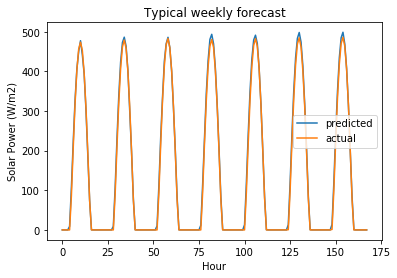

In [100]:
# user requests forecast for 1 January 2016 which we predict using data from 31 December 2015!
user_forecast_request = transformed_validation_features[[-1], :]
user_forecast_response = random_forest_randomized_search.predict(user_forecast_request)[0]
actual_values_response = validation_target.values[[-1], :][0]

# this would be rendered in Tableau!
plt.plot(user_forecast_response, label="predicted")
plt.plot(actual_values_response, label="actual")
plt.legend()
plt.title("Typical weekly forecast")
plt.ylabel("Solar Power (W/m2)")
plt.xlabel("Hour")

# Assess model performance on testing data

In [101]:
testing_features = testing_data.drop("target(W/m2)", axis=1, inplace=False)
testing_target = testing_data.loc[:, ["target(W/m2)"]]
transformed_testing_features = preprocess_features(testing_features)

In [711]:
elastic_net_predictions = elastic_net_randomized_search.predict(transformed_testing_features)
np.sqrt(metrics.mean_squared_error(testing_target, elastic_net_predictions))

19.76022744338562

In [712]:
lasso_regression_predictions = lasso_regression_randomized_search.predict(transformed_testing_features)
np.sqrt(metrics.mean_squared_error(testing_target, lasso_regression_predictions))

19.73446980783998

In [102]:
# random forest wins!
random_forest_predictions = random_forest_randomized_search.predict(transformed_testing_features)
np.sqrt(metrics.mean_squared_error(testing_target, random_forest_predictions))

19.826312994581507

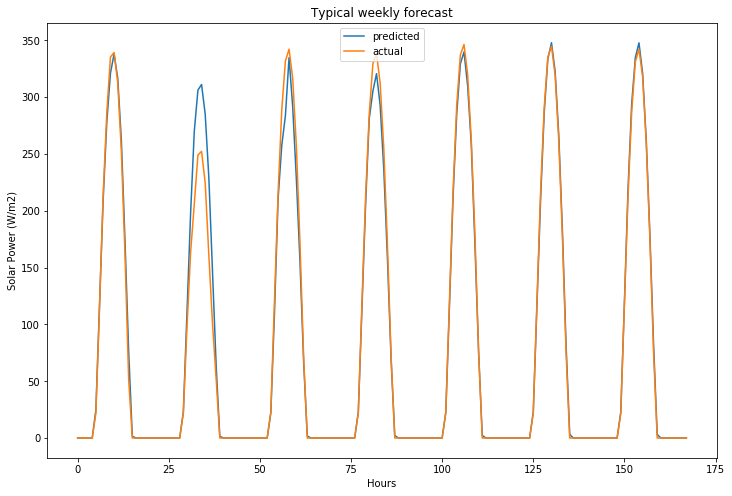

In [104]:
# user requests forecast for last week of 2018
user_forecast_request = transformed_testing_features[[-1], :]
user_forecast_response = random_forest_randomized_search.predict(user_forecast_request)[0]
actual_values_response = testing_target.values[[-1], :][0]

# this would be rendered in Tableau!
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(user_forecast_response.flatten(), label="predicted")
ax.plot(actual_values_response.flatten(), label="actual")
ax.legend()
ax.set_title("Typical weekly forecast")
ax.set_ylabel("Solar Power (W/m2)")
ax.set_xlabel("Hours")
plt.savefig("../results/img/typical-weekly-actual-vs-predicted-solar-power.png")

In [105]:
# combine the training and validtion data
combined_training_features = pd.concat([training_features, validation_features])
transformed_combined_training_features = preprocess_features(combined_training_features)
combined_training_target = pd.concat([training_target, validation_target])

# tune a random forest regressor using CV ro avoid overfitting
_prng = np.random.RandomState(42)

_param_distributions = {
    "n_estimators": stats.geom(p=0.01),
     "min_samples_split": stats.beta(a=1, b=99),
     "min_samples_leaf": stats.beta(a=1, b=999),
}

tuned_random_forest_regressor = model_selection.RandomizedSearchCV(
    ensemble.RandomForestRegressor(n_estimators=100, random_state=_prng),
    param_distributions=_param_distributions,
    scoring="neg_mean_squared_error",
    random_state=_prng,
    n_iter=10,
    cv=5,
    n_jobs=2,
    verbose=10
)

tuned_random_forest_regressor.fit(combined_training_features, combined_training_target)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  4.9min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed: 10.5min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed: 14.2min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed: 16.4min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 17.9min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 20.3min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 26.2min
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed: 28.3min finished
/Users/pughdr/Research/junctionx-kaust-2019/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                                                   n_jobs=None, oob_score=False,
                                                   random_state=...


In [106]:
tuned_random_forest_regressor.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=0.0004129137216396695,
                      min_samples_split=0.004789233605970227,
                      min_weight_fraction_leaf=0.0, n_estimators=78,
                      n_jobs=None, oob_score=False,
                      random_state=<mtrand.RandomState object at 0x1a32c13948>,
                      verbose=0, warm_start=False)

In [107]:
(-tuned_random_forest_regressor.best_score_)**0.5

18.785573993005393

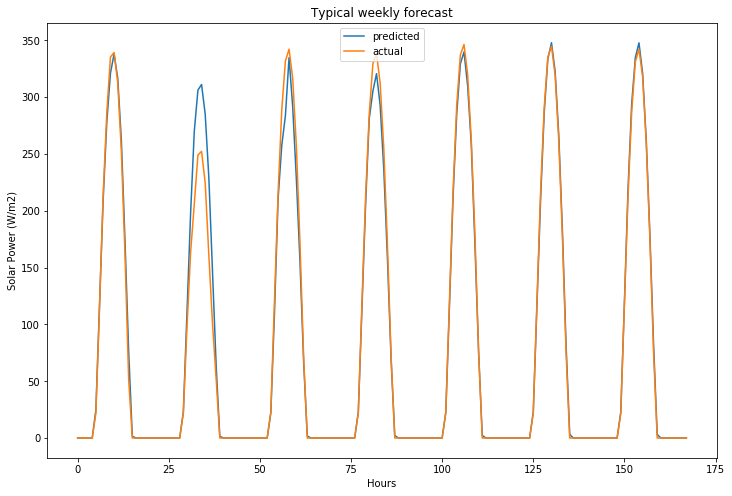

In [108]:
# user requests forecast for last week of 2018
user_forecast_request = transformed_testing_features[[-1], :]
user_forecast_response = random_forest_randomized_search.predict(user_forecast_request)[0]
actual_values_response = testing_target.values[[-1], :][0]

# this would be rendered in Tableau!
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(user_forecast_response.flatten(), label="predicted")
ax.plot(actual_values_response.flatten(), label="actual")
ax.legend()
ax.set_title("Typical weekly forecast")
ax.set_ylabel("Solar Power (W/m2)")
ax.set_xlabel("Hours")
plt.savefig("../results/img/typical-weekly-actual-vs-predicted-solar-power.png")

# Forecasting the future of solar power at NEOM

Once the model is trained, the model can generate a new forecast for next day's solar power generation. Once actual values of solar power generation are observed, model can be automatically re-trained and improved.  Model can be retrained with weekly, monthly forecast horizons if longer forecasts are required.

In [762]:
incoming_features = features.loc[[4017]]
new_predictions = tuned_random_forest_regressor.predict(incoming_features)[0]
solar_power_forecast = (pd.DataFrame.from_dict({"Timestamp": pd.date_range(start="2019-01-01", end="2019-01-01 23:00:00", freq='H'),
                                                "Predicted Solar Power (W/m2)": new_predictions})
                          .set_index("Timestamp", inplace=False))

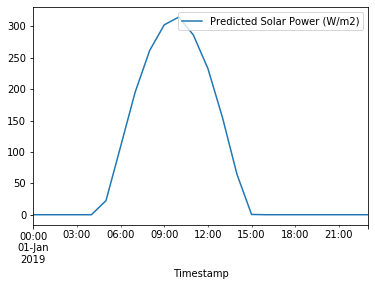

In [763]:
_ = solar_power_forecast.plot()

In [750]:
ensemble.RandomForestRegressor?

Init signature:
ensemble.RandomForestRegressor(
    n_estimators='warn',
    criterion='mse',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
)
Docstring:     
A random forest regressor.

A random forest is a meta estimator that fits a number of classifying
decision trees on various sub-samples of the dataset and uses averaging
to improve the predictive accuracy and control over-fitting.
The sub-sample size is always the same as the original
input sample size but the samples are drawn with replacement if
`bootstrap=True` (default).

Read more in the :ref:`User Guide <forest>`.

Parameters
----------
n_estimators : integer, optional (default=10)
    The number of trees in the forest.

    .. versionchanged:: 